In [19]:
# DISK FM DE functions
import os
import glob

import math as mt
import numpy as np  
import pandas as pd 

import astropy.io.fits as fits
from astropy.convolution import convolve
from astropy.wcs import FITSFixedWarning
from astropy.convolution import convolve
from astropy import constants as const
from astropy import units as u
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

import pyklip.parallelized as parallelized
from pyklip.fmlib.diskfm import DiskFM
import pyklip.fm as fm
import pyklip.rdi as rdi

import time
from datetime import datetime
import subprocess
import mcfost

from scipy.optimize import rosen, differential_evolution
# from scipy.optimize import NonlinearConstraint, Bounds
import shutil
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
import disk_convolution as dc
import numpy.ma as ma
from webbpsf_ext import bp_2mass
import DE_plot

In [6]:
model_gz = '/Users/sbetti/Documents/Science/DebrisDisks/49Ceti/disk_modeling/DiffEvo/F444W_modeling/using_F200W_params/mcfost_models/bestfit_model/data_4.44/RT.fits.gz'

In [7]:
INSTRUMENT = 'NIRCam'
WAVELENGTH = 4.44
FILTER = 'F444W'

In [10]:
REDUCEDDATA_DIR = '/Users/sbetti/Documents/Science/datasets/JWST/49Ceti_NIRCam/spaceklip_2rolls/klipsub'  
# path to reduced RDI noise data                                      
NOISE_DIR = '/Users/sbetti/Documents/Science/datasets/JWST/49Ceti_NIRCam/background/klipsub'
DATA_NAME  = 'RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASKA335R_SUB320A335R-KLmodes-all.fits'  
# number frame within reduced data
PYKLIP_FRAME = 2
# name of annulus std noise map
NOISE_NAME = 'BKG_STD_RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASKA335R_SUB320A335R-KLmodes-all.fits' 

REDUCED_DATA_MJYSR = fits.getdata(REDUCEDDATA_DIR + '/' + DATA_NAME)[PYKLIP_FRAME]  
# convert to mJy/as2
REDUCED_DATA_MJYSR = REDUCED_DATA_MJYSR * u.MJy/u.steradian
REDUCED_DATA = REDUCED_DATA_MJYSR.to(u.mJy/u.arcsecond**2)
REDUCED_DATA = REDUCED_DATA.value

# # load noise and make it global
NOISE_MJYSR = fits.getdata(NOISE_DIR + '/' + NOISE_NAME) # this is the ANNULUS STD NOISE
# convert to mJy/as2
NOISE_MJYSR = NOISE_MJYSR * u.MJy/u.steradian
NOISE = NOISE_MJYSR.to(u.mJy/u.arcsecond**2)
NOISE = NOISE.value

INITIALIZE_DIR = '/Users/sbetti/Documents/Science/DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files'
FILE_PREFIX = '49Ceti_NRCALONG_MASK335R_F444W' 
MASK = fits.getdata(INITIALIZE_DIR + '/' + FILE_PREFIX + '_MASK.fits') # mask for calculating chi2
MASK = ma.make_mask(MASK)

In [11]:
DISTANCE_STAR = 57.23
ROLL_REF_ANGLE = 261.370
OBJ_INFO = {'name': '49 Ceti',
  'sptype': 'A0V',
  'Teff': 9000, 
  'log_g': 4.0,
  'metallicity': -0.5, 
  'dist': 57.23,
  'flux': 5.458,
  'flux_units': 'vegamag',
  'bp_ref': bp_2mass('k'),
  'RA_obj': 36.48744,
  'Dec_obj':  -12.29054
}

obsdate = '2023-08-24T22:49:38.762'
grid_shape = 'circle'

In [12]:
mu = 11
amplitude = 2


In [13]:
inst, tel_point, obj_params = dc.make_psfs(ROLL_REF_ANGLE, OBJ_INFO, FILTER, obsdate=obsdate)
hdul_psfs = dc.make_psfgrid(inst, tel_point, grid_shape=grid_shape)

  --> starting make_psfs
[   webbpsf:INFO] NIRCam aperture name updated to NRCA1_FULL
[   webbpsf:INFO] NIRCam pupil mask setter: aperturename NRCA1_FULL
[   webbpsf:INFO] NIRCam aperture name updated to NRCA2_FULL_WEDGE_RND
[   webbpsf:INFO] NIRCam aperture name updated to NRCA5_FULL_MASK335R
[   webbpsf:INFO] NIRCam aperture name updated to NRCA5_MASK335R
[webbpsf_ext:INFO] Loading /Users/sbetti/data/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_F444W_CIRCLYOT_MASK335R_pix320_os2_jsig1_r0.00_th+0.0_OPD-2022-07-30_siwfe_distort_legendre.fits
[webbpsf_ext:INFO] Loading /Users/sbetti/data/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_F444W_CIRCLYOT_MASK335R_pix256_os2_jsig1_r0.00_th+0.0_OPD-2022-07-30_siwfe_distort_legendre_large_grid_wfemask.npz
iterating query, tdelta=3.0

MAST OPD query around UTC: 2023-08-24T22:49:38.762
                        MJD: 60180.9511430787

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2023082301-NRCA3_FP1-1.fits
	Date (MJD):	 60179.0914
	Delta

PSFs:   0%|          | 0/64 [00:00<?, ?it/s]

In [21]:
########################################################
def make_bestfit_model(model_gz, WAVELENGTH, DISKOBJ, REDUCED_DATA, NOISE, INSTRUMENT, DISTANCE_STAR, MASK, FILTER,
                       mu, amplitude):
    """ 
    Parameters:
        x: list of parameters for the differential evolution

    Returns:
        Chi2
    """

    wv = WAVELENGTH

    modelpixelscale = fits.getheader(model_gz)['CDELT2'] * 3600
    # convolve model with PSF 
    print('convolving')
    if INSTRUMENT == 'NIRCam': 
        model_here_convolved = dc.convolve_disk(inst, tel_point, obj_params, hdul_psfs, model_gz, modelpixelscale, wv, DISTANCE_STAR)
        pad = (REDUCED_DATA.shape[0]//2) - (model_here_convolved.shape[0]//2)
        model_here_convolved = np.pad(model_here_convolved, pad) 
        if model_here_convolved.shape[0] != REDUCED_DATA.shape[0]:
            raise ValueError('something wrong with padding')
    
    model_contrast = model_here_convolved * amplitude 
    
    print('diskFM')
    DISKOBJ.update_disk(model_contrast)
    model_fm = DISKOBJ.fm_parallelized()[0]
    model_fits = np.copy(model_fm)
   
    XX = model_fm.shape[1]
    YY = model_fm.shape[0]
    Y,X = np.mgrid[:YY,:XX]

    data = np.copy(REDUCED_DATA)
    noise = np.copy(NOISE)
    mod = np.copy(model_fm)

    for DT in [data, noise, mod]:
        DT[MASK] = np.nan
    
    N = np.count_nonzero(~np.isnan(data))
    M = mu
    v = N-M
    
    chi2 = (1./v) * np.nansum(((data - mod) / noise)**2.)
    hdr = fits.getheader(model_gz)
    hdr['AMP'] = amplitude
    hdr['CHI2'] = chi2
    print('chi2 = ', chi2)
    print('saving')
    fits.writeto(os.path.dirname(model_gz) + '/diskfm.fits', model_fits,header=hdr, overwrite=True)
    print('done')
    return os.path.dirname(model_gz) + '/'

########################################################
def initialize_diskfm(INITIALIZE_DIR, FILE_PREFIX, REDUCED_DATA):
    '''
    initialize the Diff Evo by prepearing the diskFM object 
        modeled from J. Mayozer debrisdisk_mcmc_fit_and_plot/diskfit_mcmc/initialize_diskfm()
    '''
    numbasis = [3]

    model_here_convolved = fits.getdata(INITIALIZE_DIR + '/' + FILE_PREFIX + '_FirstModelConvolved.fits')
    pad = (REDUCED_DATA.shape[0]//2) - (model_here_convolved.shape[0]//2)
    model_here_convolved = np.pad(model_here_convolved, pad, constant_values=np.nan) 
    print('model opened .. starting DiskFM')
    diskobj = DiskFM(None,
                     numbasis,
                     None,
                     model_here_convolved,
                     basis_filename=INITIALIZE_DIR + '/' + FILE_PREFIX + '_klbasis.h5',
                     load_from_basis=True)
    # test the diskFM object
    diskobj.update_disk(model_here_convolved)
    print('done diskfM')

    return diskobj

########################################################

In [15]:
diskobj = initialize_diskfm(INITIALIZE_DIR, FILE_PREFIX, REDUCED_DATA)

model opened .. starting DiskFM
done diskfM


In [28]:
amp = 3.45
make_bestfit_model(model_gz, WAVELENGTH, diskobj, REDUCED_DATA, NOISE, INSTRUMENT, DISTANCE_STAR, MASK, FILTER,
                   mu, amp)

convolving
diskFM
chi2 =  5.966234059352333
saving
done


'/Users/sbetti/Documents/Science/DebrisDisks/49Ceti/disk_modeling/DiffEvo/F444W_modeling/using_F200W_params/mcfost_models/bestfit_model/data_4.44/'

In [29]:
SAVE_DIR = '/Users/sbetti/Documents/Science/DebrisDisks/49Ceti/disk_modeling/DiffEvo/F444W_modeling/using_F200W_params/mcfost_models/bestfit_model/'
BESTMOD_DIR = SAVE_DIR + 'data_4.44/'

   ==> using existing fits files
0.0014642666


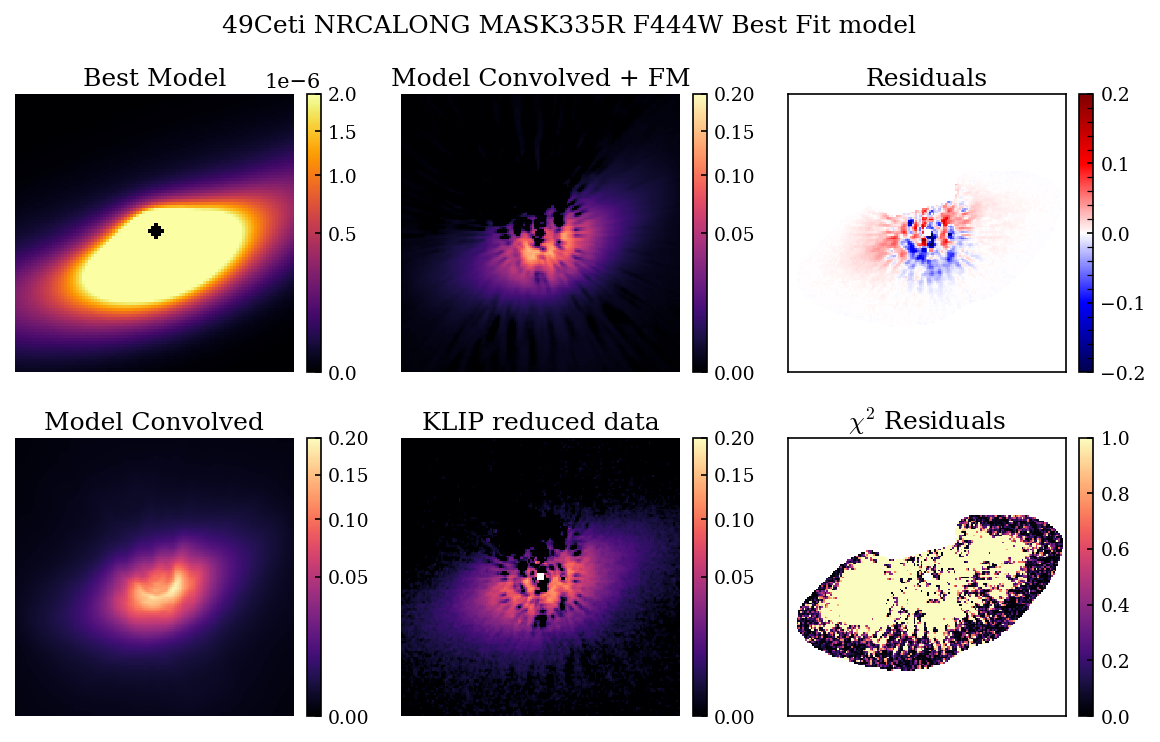

In [30]:
modelplot_kw = {'stretch':'sqrt', 'vmin':0, 'vmax':0.2, 'origvmin':0, 'origvmax':2e-6, 'resvmin':-0.2, 'resvmax':0.2}

DE_plot.make_final_images(os.path.dirname(SAVE_DIR), BESTMOD_DIR, REDUCED_DATA, NOISE, FILTER, FILE_PREFIX, MASK=MASK,
            title = FILE_PREFIX.replace('_', ' ') + ' ' + 'Best Fit model', 
                    savefig=os.path.dirname(SAVE_DIR) + f'/{FILE_PREFIX}_DEmodel.png', 
                                      **modelplot_kw)